In [1]:
# # getting data
# import sys
# import os

# # getting the name of the directory where this file is present
# current = os.path.dirname(os.path.realpath('00_working_explore.ipynb'))

# # getting the parent directory
# parent = os.path.dirname(current)

# # adding the directory to the sys,path
# sys.path.append(parent)

from wrangle import wrangle_data, get_clean_mac, get_2020_census_data, get_2020_census_labels, split_data

# getting exploration pmodules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# feature selection
from sklearn.feature_selection import SelectKBest

# Exploration 1

In [75]:
def univariate_visulization(df):

    cat_cols, num_cols, td_cols = [], [], []
    
    for col in df.columns:
        if df[col].dtype == "O":
            cat_cols.append(col)
        
        elif df[col].dtype == "timedelta64[ns]":
            
            td_cols.append(col)
        
        else:
            if df[col].nunique() < 5:
                cat_cols.append(col)
            else:
                num_cols.append(col)
    explore_cols = cat_cols + num_cols + td_cols
    print(f'cat_cols: {cat_cols}')
    print(f'num_cols: {num_cols}')
    print(f'td_cols: {td_cols}')
    for col in explore_cols:
        if col in cat_cols:
            print(f'Univariate assessment of feature {col}:')
            sns.countplot(data=df, x=col, color='turquoise', edgecolor='black')
            plt.xticks(rotation=90)
            plt.show()
        if col in num_cols:
            print(f'Univariate feature analysis of feature {col}: ')
            plt.hist(df[col], color='turquoise', edgecolor='black')
            plt.xticks(rotation=90)
            plt.show()
            df[col].describe()
        if col in td_cols:
            print(f'Univariate feature analysis of feature {col}: ')
            plt.hist(df[col]/pd.Timedelta(days=1), color='turquoise', ec='black')
            plt.show()
            df[col].describe()
    print('_____________________________________________________')
    print('_____________________________________________________')
    print()

## Get wrangled data
The target variable is the the feature 'close_time' which is the amount of time it took to close the booking

In [2]:
# acquire data
df, train, validate, test = wrangle_data()

No stratification applied during the split


In [6]:
# quick examination of train
train.head()
# train.columns.values

,keyword,subcategory,incident_address,township,city,zip,council_district,created,last_modified,closed,...,percent_housing_occupancy_total_housing_units_vacant_housing_units_all_other_vacants,count_vacancy_rates_homeowner_vacancy_rate_(percent)_[4],count_vacancy_rates_rental_vacancy_rate_(percent)_[5],count_housing_tenure_occupied_housing_units,count_housing_tenure_occupied_housing_units_owner-occupied_housing_units,percent_housing_tenure_occupied_housing_units_owner-occupied_housing_units,count_housing_tenure_occupied_housing_units_renter-occupied_housing_units,percent_housing_tenure_occupied_housing_units_renter-occupied_housing_units,geography,geographic_area_name
66653,Chuckhole,Street (Chuckhole),914 E NEW YORK ST,CENTER,INDIANAPOLIS,46202,17.0,2018-06-07 12:19:35+00:00,2018-06-19 13:38:45+00:00,2018-06-19 13:38:44+00:00,...,2.6,5.1,9.9,11168,2863,25.6,8305,74.4,871Z200US1846202,"ZCTA5 46202, Indiana"
547293,Trash,Heavy,7419 E EDGEWOOD AVE,FRANKLIN,INDIANAPOLIS,46239,25.0,2019-11-15 21:34:41+00:00,2019-11-18 15:32:27+00:00,2019-11-18 15:32:25+00:00,...,1.0,0.8,6.9,11509,9236,80.3,2273,19.7,871Z200US1846239,"ZCTA5 46239, Indiana"
265669,Debris/Litter,Debris in Alley/Street,5905 BEAU JARDIN DR,FRANKLIN,INDIANAPOLIS,46237,18.0,2019-12-29 21:03:24+00:00,2020-05-19 17:45:35+00:00,2020-01-03 13:47:20+00:00,...,0.5,0.8,7.7,17188,11686,68.0,5502,32.0,871Z200US1846237,"ZCTA5 46237, Indiana"
493412,Chuckhole,Street (Chuckhole),215 S GERMAN CHURCH RD,WARREN,INDIANAPOLIS,46229,19.0,2019-02-13 01:15:17+00:00,2019-02-21 18:33:06+00:00,2019-02-21 18:33:05+00:00,...,0.8,1.2,8.8,11149,6255,56.1,4894,43.9,871Z200US1846229,"ZCTA5 46229, Indiana"
211240,Animal,Human Attack (Bite),5219 HONEY COMB LN,DECATUR,INDIANAPOLIS,46221,20.0,2017-04-17 13:42:10+00:00,2017-04-18 12:48:24+00:00,2017-04-18 12:48:19+00:00,...,2.4,1.3,8.9,10311,6270,60.8,4041,39.2,871Z200US1846221,"ZCTA5 46221, Indiana"


#### Note:
I may have bitten off more than i can chew
I will begin with only using the mac data and exploring those relationships first

## Mac Data exploration prep

In [2]:
# get data
df = get_clean_mac()

# split data
train, validate, test = split_data(df)


No stratification applied during the split


In [ ]:
train = train.drop('incident_address', axis=1)
# train = train.drop('state', axis=1)
univariate_visulization(train)
for col in train.columns:
    if train[col].dtype != 'O':
        print(col)

In [ ]:
print()
td = train['close_time'] 

# print(td)

td.astype('timedelta64[s]')

(td / pd.Timedelta(minutes=1)).hist()

# the very far ones are the open cases
# lets narrow and focus on the closed cses onluy

In [20]:
def remove_outliers(df, k=1.5):
    '''
    Actions: removies outliers using the IQR with a default k of 1.5
    '''
    # initialize dictionary
    col_qs = {}
    
    # assign column names to variable
    df_cols = df.columns
    
    # creates a list of column names
    df_cols = df_cols.to_list()
    
    # remove cat cols
    cat_cols = ['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district', 'status', 'origin']

    for col in cat_cols:
        df_cols.remove(col)

    # for each column
    for col in df_cols:
        
        # create qualtiles and put them in a dict
        col_qs[col] = q1, q3 = df[col].quantile([0.25, 0.75])

    # for each col
    for col in df_cols:    
        
        # calculate the iqr
        iqr = col_qs[col][0.75] - col_qs[col][0.25]
        
        # calculate the lower fence
        lower_fence = col_qs[col][0.25] - (iqr*k)
        
        # calculates the upper fence
        upper_fence = col_qs[col][0.75] + (iqr*k)
        
        # remove outliers from df for each column
        df = df[(df[col] > lower_fence) & (df[col] < upper_fence)]
        
    # exit df and return new df
    return df

In [22]:
remove_outliers(train).shape, train.shape

((425795, 12), (513312, 12))

In [28]:
for col in train.columns:
    if train[col].dtype == 'datetime64[ns, UTC]':
        print(col)

created
last_modified
closed


In [27]:
closed = train[train['status'] == 'Closed']

67887    12 days 01:19:09
560742    2 days 17:57:44
274255    4 days 16:43:56
505800    8 days 17:17:48
218087    0 days 23:06:09
               ...       
673173    1 days 02:09:22
928960    0 days 00:26:57
53807     3 days 05:59:18
722074    1 days 03:38:26
211520    5 days 15:42:16
Name: close_time, Length: 494104, dtype: timedelta64[ns]

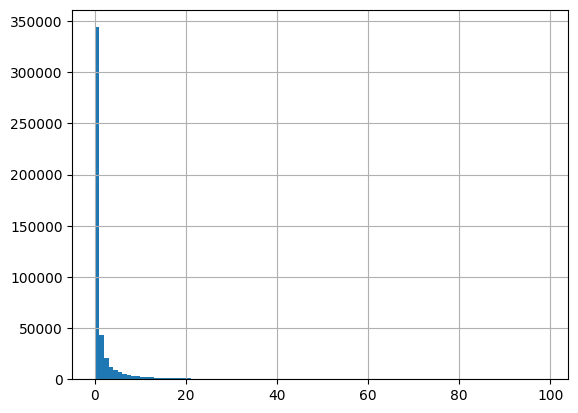

In [74]:
# the vast majority of items are resolved in a weekwith some even less days
(closed['close_time'].astype('timedelta64[s]') / pd.Timedelta(days=7)).hist(bins=range(0,100,1))

closed['close_time']

#### Notes:
* The vast majority of itenms and requests are resolved within a week, which is pretty good. The question is - what items are taking extremely long? Why is it taking so long?
* Next, it is time to get the questions for each category of group
* for this iteration of exploration - I iwll remain with a simple approach.
    * Drop all oother dattime items for the categorical exploration 
    * Explore to see if the time of year the request was created impacts the time it takes to resolve the issue. Lets replan and make a new game plan with all the questions that we want to explore

#### Actions:
 * Get initial questiosn written during the prep stage of the mac data
 * Focus on the closed status items only - i'm not sure how to handle the open ones yet som I will come back to that later

## MAC Cat Variable Exploration for Closed status

In [62]:
# preparing
# dropping the datetime stuff and only keeping the cat cols and the target
cat_cols = [col for col in closed.columns if closed[col].dtype == 'O' or col == 'close_time']

# checking columns
print(cat_cols,'\n\n',closed.columns)

# new df
closed_cat = closed[cat_cols]

# dropping status bc they are all closed
closed_cat = closed_cat.drop('status', axis=1)

['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district', 'status', 'origin', 'close_time'] 

 Index(['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district',
       'created', 'last_modified', 'closed', 'status', 'origin', 'close_time'],
      dtype='object')


cat_cols: ['keyword', 'subcategory', 'township', 'city', 'zip', 'council_district', 'origin']
num_cols: []
td_cols: ['close_time']
Univariate assessment of feature keyword:


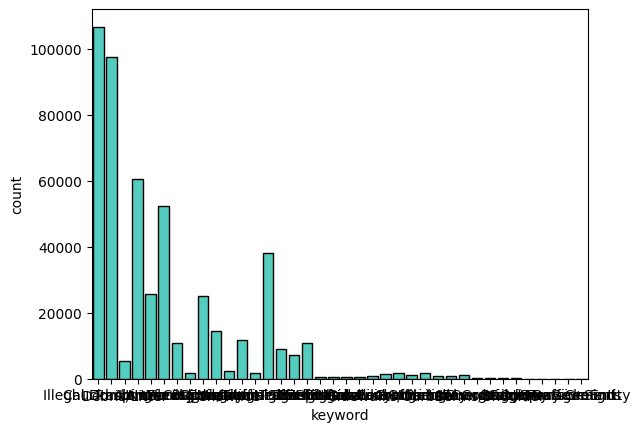

Univariate assessment of feature subcategory:


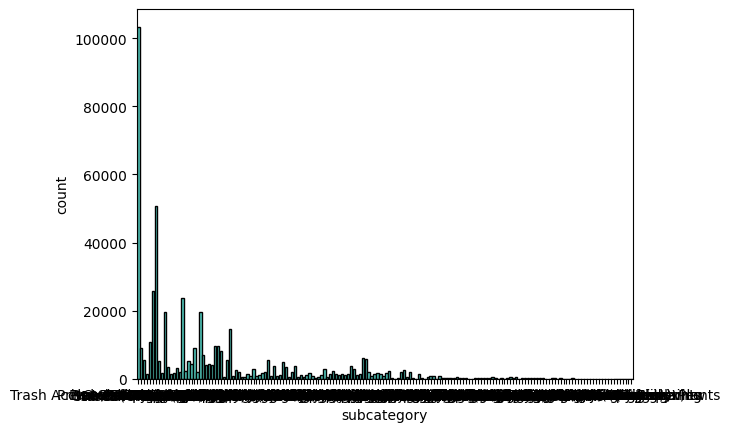

Univariate assessment of feature township:


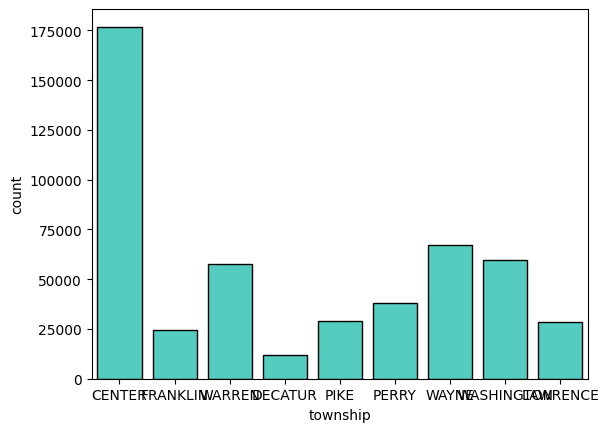

Univariate assessment of feature city:


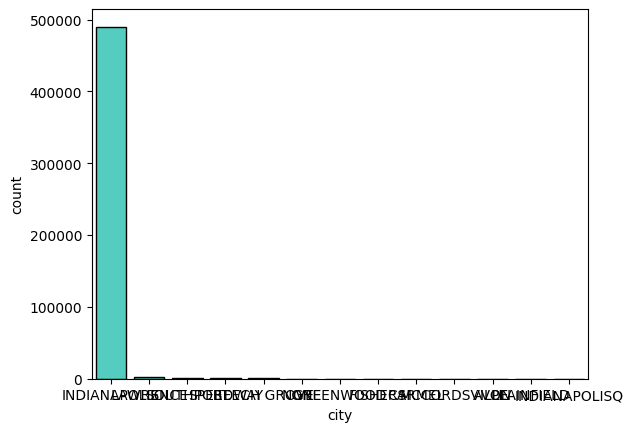

Univariate assessment of feature zip:


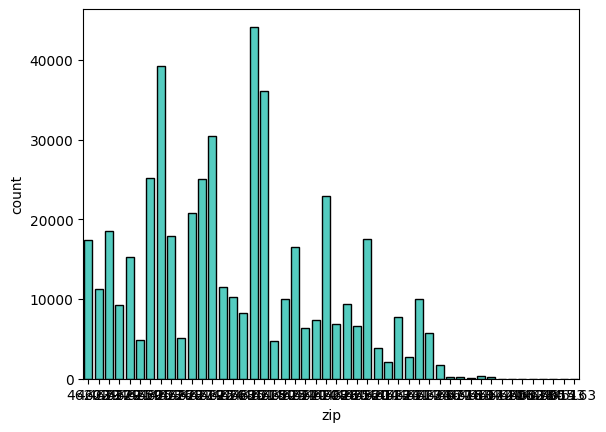

Univariate assessment of feature council_district:


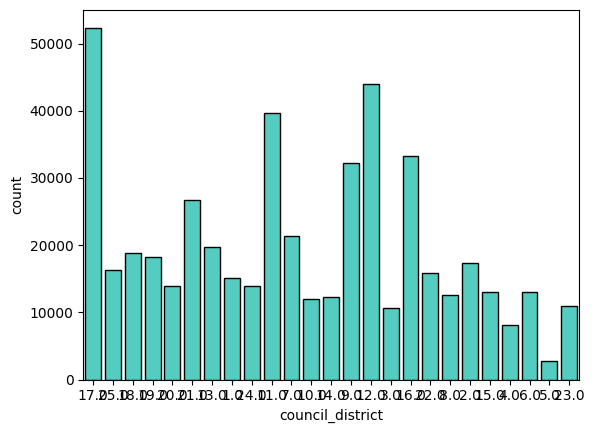

Univariate assessment of feature origin:


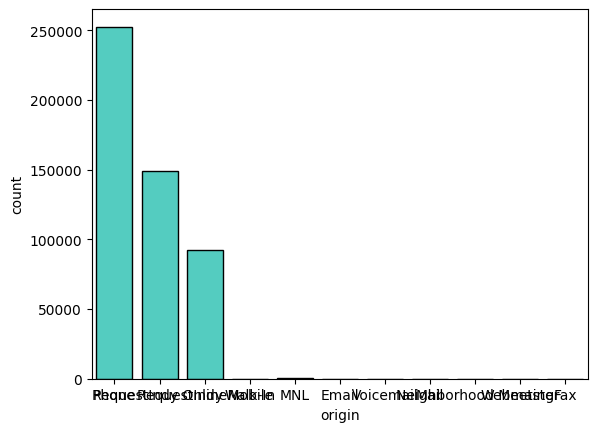

Univariate feature analysis of feature close_time: 


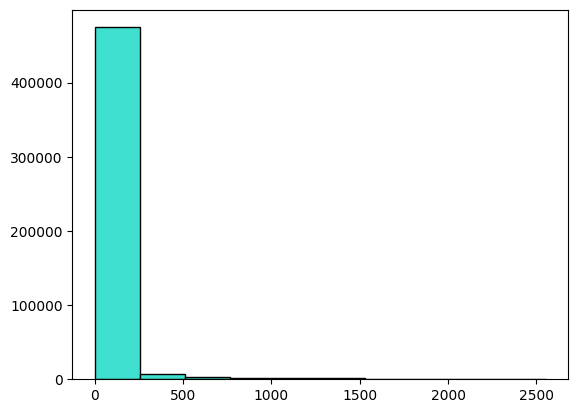

_____________________________________________________
_____________________________________________________



In [73]:
# hit the univariate again 
univariate_visulization(closed_cat)